Analyse how our approximation

\begin{equation}
    \text{tr} \left( K^{-1} \frac{dK}{d\theta} \right) \approx \frac{1}{S} \sum_{i=1}^S z_i^T C^{-1} \frac{dK}{d\theta} z_i; \quad z_i \sim N(0, I)
\end{equation}
changes for a 1D problem, as we vary $\theta$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lazy_GP import GP
%matplotlib inline
gp = GP()

Generate some input data (we don't need targets for this analysis)

In [2]:
np.random.seed(42)
N = 100
D = 1
X = np.vstack(np.linspace(0, 10, N))
sigma = 0.1
y = np.sin(X) + sigma * np.random.randn(N, 1)

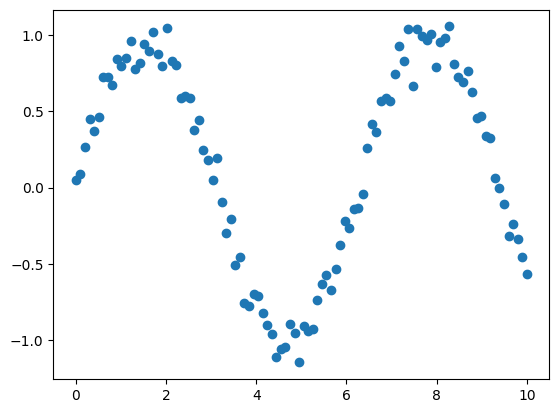

In [3]:
fig, ax = plt.subplots()
ax.plot(X, y, 'o')
plt.show()

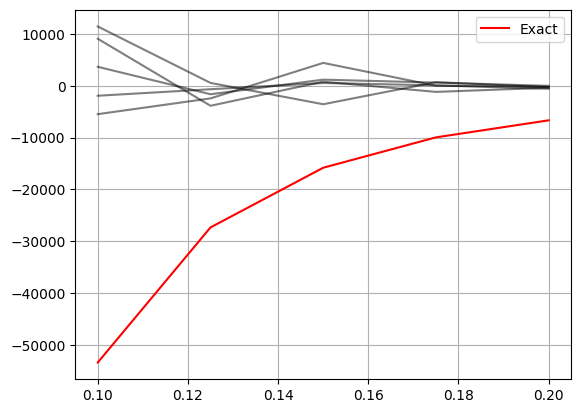

In [4]:
fig, ax = plt.subplots()

for n in range(5):
    theta = np.array([1., 1.])
    theta0_array = np.linspace(0.1, 0.2, 5)
    d_dash = 0
    exact_term = []
    mc_estimate = []
    for theta0 in theta0_array:
        theta[0] = theta0
        K, C, inv_C, dK_dtheta = gp._find_exact_matrices(X=X, theta=theta, sigma=sigma, d_dash=d_dash)
        exact_term.append(np.trace(inv_C @ dK_dtheta))
        mc_estimate.append(gp._tr_invK_dK(X=X, theta=theta, sigma=sigma, d_dash=d_dash, S=10))    
    ax.plot(theta0_array, mc_estimate, color='black', alpha=0.5)
ax.plot(theta0_array, exact_term, color='red', label='Exact')
ax.grid()
ax.legend()
plt.show()